# ANN to SNN translation via layer-wise optimization 
This notebook demonstrates a novel technique for the translation of conventional analog neural networks (ANN) communicating via continuous 32-bit signals to spiking neural networks (SNN) communicating in 1-bit pulses through synaptic filters. This method is demonstrated in the Nengo neural simulation framework. It successfully translates a policy network trained via basic stochastic gradient descent for the Open AI Gym Cart Pole environment. The network is translated using a variety of settings and the results are compared on the basis of relative error with the ANN over a range of sample inputs spanning the expected problem domain. 

In addition to successfully translating the ANN, this notebook also demonstrates a novel method of general network compression via neuron pruning. This method decomposes neural activity by the singular value decomposition (SVD) and solves the least-square error problem for the reconstructed weights. This is a variation of previously proposed decomposition-based pruning methods which operate directly on the weight matricies. 

## Setup the Notebook
Just importing the required modules 

In [1]:
import numpy as np 
# import cvxpy
import matplotlib.pyplot as plt

import nengo 
from nengo.dists import Choice 
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot
from nengo.neurons import Direct

# import tensorflow as tf
import gym
import pickle 

import pdb

## ANN Setup
We are translating an ANN trained via SGD for the Cart Pole problem using the TensorFlow framework. The network is a fully-connected MLP with three layers and ReLU activations. The input dimension is four, the two hidden layer dimensions are 64, and the output dimension is two. The actions represent un-normalized logits of the discrete action space probabilites. 

Here we import the weights of the previously trained network. Once imported, we rebuild an analogous network in Nengo using the ReLU neuron type. We make the connections direclty to and from ensemble neurons to ensure we completely control the input and output weightings. 

In [2]:
dnn_weights = pickle.load(open('./Weights/DNN_weights.p', 'rb'))
dnn_layers = len(dnn_weights)
dnn_activations = pickle.load(open('./Weights/activations.p', 'rb'))
h = 64

INPUT_DIMS = 4
OUTPUT_DIMS = 2
CLOCK = 1000.0

def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

In [3]:
previous_factor = 1.0
scaled_weights = []
for layer, weight in enumerate(dnn_weights[:2]):
    max_act = np.amax(dnn_activations[layer])
    max_wt = np.amax(weight)
    scale_factor = np.max((max_act, max_wt))
    applied_factor = scale_factor/previous_factor
    scaled_weights.append(weight/applied_factor)
    previous_factor = scale_factor 
scaled_weights.append(dnn_weights[2]*previous_factor)

In [4]:
N = 10000
ANN = nengo.Network()
ANN_layers = {}
with ANN: 
    for i, weight in enumerate(dnn_weights):
        dim = weight.shape[0]
        size = weight.shape[1]
        ANN_layers[i] = nengo.Ensemble(size, 
                            dimensions=dim,
                            encoders=weight.T,
                            neuron_type=nengo.RectifiedLinear(),
                            gain = np.ones([size,]),
                            bias = np.zeros([size,]),
                            normalize_encoders=False
                            )

    input_node = nengo.Node(lambda t: observation, 
                           size_out=dnn_weights[0].shape[0]
                           )

    nengo.Connection(input_node, ANN_layers[0],
                     synapse = 0,
#                      transform = dnn_weights[0].T
                    )
    
    nengo.Connection(ANN_layers[0].neurons, ANN_layers[1],
                     synapse = 0,
#                      transform = dnn_weights[1].T
                    )
    
    nengo.Connection(ANN_layers[1].neurons, ANN_layers[2],
                    synapse = 0,
#                      transform = dnn_weights[2].T
                    )

    inp = nengo.Probe(input_node, 
                      synapse = 0)
    l0 = nengo.Probe(ANN_layers[0].neurons, 
                      synapse = 0)
    l1 = nengo.Probe(ANN_layers[1].neurons, 
                       synapse = nengo.synapses.LinearFilter([1],[1, 0], analog=False))
    l2 = nengo.Probe(ANN_layers[2].neurons, 'input', 
                      synapse = 0)

ann_activations = {}
evals = np.random.normal(loc=0.0, scale=1.0, size=[N,dnn_weights[0].shape[0]])
for i in range(3):
    with nengo.Simulator(ANN) as sim: 
        _, ann_activations[i] = tuning_curves(ANN_layers[i], sim, inputs=evals) 
    evals = ann_activations[i]


TypeError: __init__() got an unexpected keyword argument 'normalize_encoders'

## Test ANN 
Now that the ANN is built, we'll test it on the CartPole environment to make sure it achieves the expected score of 200. 

In [5]:
env = gym.make('CartPole-v0')

[2017-06-01 13:55:58,927] Making new env: CartPole-v0


In [129]:
observation = env.reset()
done = False
score = 0.0
T = 0.1
observation_list = [observation]
while not done: 
    with nengo.Simulator(ANN) as sim: 
        sim.run(T, progress_bar=False)
    out_1 = sim.data[l2][:,0].mean()
    out_2 = sim.data[l2][:,1].mean()
    aprob = softmax([out_1,out_2])
    action = np.random.choice(OUTPUT_DIMS, p=aprob)
    observation, reward, done, info = env.step(action)
    score += reward
    observation_list.append(observation)
    
print(score)

Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01. 

## SNN Translation 
The cell below defines the translation function. It accepts the ANN model and dictionary of layers as an input and provides all the SNN components as an output. It also provides a list of the solved for encoders in case it is desired to use a framework other than Nengo for the SNN simulation. This function requires Nengo in its current form, however, a module may be constructed that does not rely on Nengo in the future. 

In [183]:
def snn_translalte(model, layers, weights, sizes, rels=None, round=None, samples=10000, eval_points=None, radius=1.0, neuron_type='LIF'):
    ''' Function translates a model of a fully-connected analog neural network (ANN) to an 
    equivalent spiking neural network (SNN). SNN takes input from global variable 'snn_input' by default. 
    This function requires Nengo version 2.4x 
    model: Nengo Network
        Model of analog neural network (ANN) specified as nengo model with non-spiking neurons 
        (will expand to TensorFlow later)
    layers: List
        List containing the layers (ensembles) of the ANN model 
    weights: List
        List of ANN layer weights of dimensions (IN, OUT). This should be eliminated in future
        versions 
    sizes: List (layers)
        List containing the number of neurons for each layer of the SNN. Should be the same 
        length as the number of layers in the ANN model 
    rels: List (layers), Default=None
        List containing the number of singular value basis functions (U-basis vectors) to be 
        used for each translation. If None, then the basis will not be truncated 
    round: Int or None, Default=None
        Number of decimals the basis vectors should be rounded to after SVD. If None, then 
        no rounding will occur
    samples: Int, Default=10000
        Number of samples to take for decoder regression
    radius: Int or Float, default=1.0
        Raius of samples taken for regression 
    neuron_type: string
        Nengo neuron model to employ for SNN. Currently only Leaky-Integrate-and-Fire is 
        supported (LIF)
    '''
    input_dim = weights[0].shape[0]
#     evals = np.random.uniform(-radius, radius, size=[samples,input_dim])
    if eval_points is None: 
        evals = np.random.normal(loc=0.0, scale=radius, size=[samples, input_dim])
    else:
        evals=eval_points
    A = evals[:]
    
    ann_activations = {}
    ann_activations[0] = A
    for i in range(len(sizes)):
        with nengo.Simulator(model) as sim: 
            _, ann_activations[i+1] = tuning_curves(layers[i], sim, inputs=A) 
        A = ann_activations[i+1]
    
    encoders = {}
    for i in range(len(sizes)):
        size = sizes[i]
        F = ann_activations[i].dot(weights[i])
        U, s, V = np.linalg.svd(F,full_matrices=False)
        V_ = V[:size, :size]
        S = np.diag(s)
        S_ = S[:,:size]
        if rels is not None: 
            rel = rels[i]
            U_ = U[:,:rel]
            S_ = S_[:rel, :]
        else: 
            U_ = U
        F_ = (U_.dot(S_)).dot(V_) #Truncated target function 
        
        if i == 0:
            a = evals
        else:
            test_model = nengo.Network()
            with test_model:
                dim = size
                ens = nengo.Ensemble(size, 
                                    dimensions=dim,
                                    encoders=np.identity(size),
                                    neuron_type=nengo.LIF(),
                                    gain = np.ones([size,]),
                                    bias = np.zeros([size,]),
                                    normalize_encoders=False
                                    )
            with nengo.Simulator(test_model) as sim: 
                _, a = tuning_curves(ens, sim, inputs=evals)
        u, s, v = np.linalg.svd(a, full_matrices=False)
        s_ = np.diag(s)
        if rels is not None: 
            rel = rels[i]
            u_ = u[:,:rel]
            s_ = s_[:rel, :]
        else: 
            u_ = u
        a_ = (u_.dot(s_)).dot(v)
        #This solver may be different for constrained solutions 
        enc = np.linalg.pinv(a_).dot(F_)
        encoders[i] = enc
        evals = a.dot(enc)
    
    #Build the Network 
    prior_size = input_dim
    snn = nengo.Network()
    snn_layers = {}
    with snn: 
        inp = nengo.Node(lambda t: snn_input)
        for i in range(len(sizes)):
            size = sizes[i]
            snn_layers[i] = nengo.Ensemble(size, 
                                dimensions=prior_size,
                                encoders=encoders[i].T,
                                neuron_type=nengo.LIF(),
                                gain = np.ones([size,]),
                                bias = np.zeros([size,]),
                                normalize_encoders=False
                                )
            prior_size = size
            if i == 0:
                nengo.Connection(inp, snn_layers[i],
                                synapse = 0.0005)
            else: 
                nengo.Connection(snn_layers[i-1].neurons, snn_layers[i],
                                synapse = 0.0005)
                
        in_probe = nengo.Probe(inp, synapse=0.01, label='in_probe')
        out_probe = nengo.Probe(snn_layers[len(sizes)-1].neurons, 'input', 
                          synapse=0.0005, label='out_probe')
    return snn, inp, in_probe, out_probe, snn_layers
            
        

## Demonstration 
This technique is first demonstrated on translation with the default settings, with one-to-one network sizes.
Note the default input variable "snn_input" must be defined BEFORE translating the network. This may be defined as a placeholder value. 

In [208]:
snn_input = np.array([.50, .50, -1.0, -1.0])
SNN, inp, in_probe, out_probe, SNN_layers = snn_translalte(ANN, ANN_layers, dnn_weights, [24, 24, 2], rels=[12,12,12], round=None, samples=10000, eval_points=None, radius=1.0, neuron_type='LIF')

Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   
Building finished in 0:00:01.                                                                   


Building finished in 0:00:01.                                                                   
Simulating finished in 0:00:01.                                                                 
Building finished in 0:00:01.                                                                   
Simulating finished in 0:00:01.                                                                 


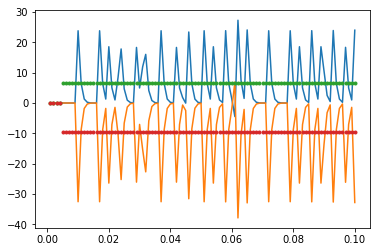

ANN output: array([ 6.70288489, -9.6360922 ])
SNN output: array([ 7.0764915 , -9.76281603])
Relative Error 0.03062189522330705


In [209]:
observation = np.array([1.0, 0.01, -.10, -.10])
scale = np.mean(observation)
snn_input = observation/scale
T_INT = 0.1
with nengo.Simulator(SNN) as sim:
    sim.run(T_INT)
    
with nengo.Simulator(ANN) as sim2:
    sim2.run(T_INT)

plt.figure()
plt.plot(sim.trange(), sim.data[out_probe]*scale)
plt.plot(sim2.trange(), sim2.data[l2],'.')

# plt.figure()
# rasterplot(sim.trange(), sim.data[out_probe])
plt.show()

ann_out = np.mean(sim2.data[l2][20:,:], axis=0)
snn_out = np.mean(sim.data[out_probe][20:,:], axis=0)*scale

rel_err = (np.abs(ann_out[0] - snn_out[0])+np.abs(ann_out[1] - snn_out[1]))/(np.abs(ann_out[0]) + np.abs(ann_out[1])) 

print('ANN output: %r' % ann_out)
print('SNN output: %r' % snn_out)
print('Relative Error %r' % rel_err)

# Theory 
$$ \mathbf{F_i} = G(\mathbf{X_i}) \cdot \mathbf{W_i}$$
$$ \mathbf{U \Sigma V} = SVD(\mathbf F)$$
$$ \mathbf V_{Trunc} = \mathbf V(1:Target Size, 1:Target Size) $$
$$ \mathbf U_{Trunc} = \mathbf U(1:singular values, 1:singular values) $$ 
$$ \mathbf{F'}  = \mathbf{U_{Trunc}\Sigma_{Trunc}V_{Trunc}}$$
$$ \mathbf{a_i} = g(\mathbf{X_i})$$
$$ \mathbf{a_i \Phi_i} = \mathbf F' $$
$$ \mathbf{\Phi_i} = pseudo_inv(\mathbf{a_i F'}) $$


In [1]:
N = 5
T = 0.1
error = []
score = 0.0
for i in range(N):
    done = False
    observation = env.reset()
    while not done: 
        scale = np.mean(observation)
        snn_input = observation/scale
        with nengo.Simulator(SNN) as sim:
            sim.run(T_INT, progress_bar=False)
        with nengo.Simulator(ANN) as sim2:
            sim2.run(T_INT, progress_bar=False)
        
        ann_out = np.mean(sim2.data[l2][20:,:], axis=0)
        snn_out = np.mean(sim.data[out_probe][20:,:], axis=0)*scale
        snn_aprob = softmax(snn_out)
        rel_err = (np.abs(ann_out[0] - snn_out[0])+np.abs(ann_out[1] - snn_out[1]))/(np.abs(ann_out[0]) + np.abs(ann_out[1]))
        error.append(rel_err)
        action = np.random.choice(OUTPUT_DIMS, p=snn_aprob)
        observation, reward, done, info = env.step(action)
        score += reward
        

NameError: name 'env' is not defined